In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/My Drive/Reddit_Encoded(No Stop Words).csv'
df = pd.read_csv(file_path)
print(df.head())

                                             comment  hate_speech  \
0  subsection retarded hungarians ohh boy brace l...            1   
1  hiii just got work foundation grounding mainly...            0   
2                    wow guess soyboys every country            0   
3  owen benjamins soyboy song goes every country ...            0   
4  yall hear sumn means live small town right now...            0   

                                  lemmatized_comment  \
0  subsection retard hungarians ohh boy brace liv...   
1  hiii just get work foundation ground mainly ty...   
2                    wow guess soyboys every country   
3  owen benjamins soyboy song go every country th...   
4  yall hear sumn mean live small town right now ...   

                                document_vector_flat  
0  0.014043219,-0.01809359,0.017145459,0.08062436...  
1  -0.0031560725,-0.033554427,0.019422462,0.07846...  
2  0.017362628,0.005587179,0.0297773,0.109146975,...  
3  0.0122448,0.00724816,-5.1

In [4]:
# Convert the document vectors from their string representation back into numerical form
df['document_vector'] = df['document_vector_flat'].apply(lambda x: np.fromstring(x, sep=','))
print(df['document_vector'].head())

0    [0.014043219, -0.01809359, 0.017145459, 0.0806...
1    [-0.0031560725, -0.033554427, 0.019422462, 0.0...
2    [0.017362628, 0.005587179, 0.0297773, 0.109146...
3    [0.0122448, 0.00724816, -5.1360163e-05, 0.0789...
4    [0.015154357, 0.010861638, 0.018671766, 0.0720...
Name: document_vector, dtype: object


In [5]:
# Extract features (document vectors) and labels (binary hate speech)
X = np.array(df['document_vector'].tolist())
y = df['hate_speech']

# Check the shape of the dataset
print(X.shape)  # Expected shape: (num_samples, embedding_dim)
print(y.shape)  # Expected shape: (num_samples,)

(22178, 300)
(22178,)


## Split the data into train and test set

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Balance the data

In [7]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Shape data to match Conv1D Input Shape

In [8]:
X_train_resampled = np.array(X_train_resampled)

# Check the shape of the resampled dataset
print(X_train_resampled.shape)  # Expected shape: (num_samples, embedding_dim)
print(y_train_resampled.shape)  # Expected shape: (num_samples,)

(27022, 300)
(27022,)


In [9]:
# Reshape train data to match Conv1D input shape: (num_samples, embedding_dim, 1)
X_train_resampled = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
print(X_train_resampled.shape)

(27022, 300, 1)


In [ ]:
# Reshape test data to match Conv1D input shape: (num_samples, embedding_dim, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_test.shape)  # Should be (num_samples, 1, embedding_dim)

## Single Conv1D Layer

In [11]:
# Define the CNN model
model1 = Sequential()

# Add a Conv1D layer
model1.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model1.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model1.add(Flatten())

# Add a Dense layer
model1.add(Dense(128, activation='relu'))
# Add a Dropout layer to prevent overfitting
model1.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model1.add(Dense(1, activation='sigmoid'))

# Compile the model
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 296, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 18944)             0         
                                                                 
 dense (Dense)               (None, 128)               2424960   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [12]:
model1.fit(X_train_resampled, y_train_resampled,
           validation_split=0.2,
           epochs=50,
           batch_size=64)

Epoch 1/50
338/338 [==============================] - 9s 7ms/step - loss: 0.4898 - accuracy: 0.7671 - val_loss: 0.5629 - val_accuracy: 0.7040
Epoch 2/50
338/338 [==============================] - 2s 7ms/step - loss: 0.4077 - accuracy: 0.8210 - val_loss: 0.4773 - val_accuracy: 0.7819
Epoch 3/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3866 - accuracy: 0.8338 - val_loss: 0.5010 - val_accuracy: 0.7676
Epoch 4/50
338/338 [==============================] - 3s 7ms/step - loss: 0.3793 - accuracy: 0.8392 - val_loss: 0.5026 - val_accuracy: 0.7660
Epoch 5/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3681 - accuracy: 0.8459 - val_loss: 0.5285 - val_accuracy: 0.7288
Epoch 6/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3611 - accuracy: 0.8481 - val_loss: 0.4227 - val_accuracy: 0.8187
Epoch 7/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3557 - accuracy: 0.8543 - val_loss: 0.4499 - val_accuracy: 0.7937
Epoch 

In [13]:
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


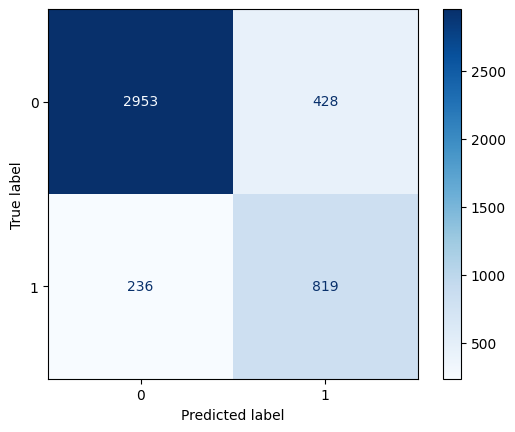

In [14]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8503
Precision: 0.6568
Recall: 0.7763
F1 Score: 0.7116


## Two Conv1D Layers

In [16]:
# Define the CNN model
model2 = Sequential()

# Add the first Conv1D layer
model2.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))
model2.add(MaxPooling1D(pool_size=2))

# Add a second Conv1D layer
model2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model2.add(Flatten())

# Add a Dense layer
model2.add(Dense(128, activation='relu'))
# Add a Dropout layer to prevent overfitting
model2.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model2.add(Dense(1, activation='sigmoid'))

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 296, 128)          768       
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 148, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 146, 64)           24640     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 73, 64)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 4672)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [17]:
model2.fit(X_train_resampled, y_train_resampled,
           validation_split=0.2,
           epochs=50,
           batch_size=64)

Epoch 1/50
338/338 [==============================] - 5s 7ms/step - loss: 0.5282 - accuracy: 0.7348 - val_loss: 0.6502 - val_accuracy: 0.6411
Epoch 2/50
338/338 [==============================] - 2s 5ms/step - loss: 0.4274 - accuracy: 0.8090 - val_loss: 0.4874 - val_accuracy: 0.7983
Epoch 3/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3929 - accuracy: 0.8296 - val_loss: 0.4283 - val_accuracy: 0.8194
Epoch 4/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3736 - accuracy: 0.8426 - val_loss: 0.3585 - val_accuracy: 0.8535
Epoch 5/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3606 - accuracy: 0.8465 - val_loss: 0.4158 - val_accuracy: 0.8198
Epoch 6/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3503 - accuracy: 0.8520 - val_loss: 0.4476 - val_accuracy: 0.7944
Epoch 7/50
338/338 [==============================] - 2s 7ms/step - loss: 0.3426 - accuracy: 0.8558 - val_loss: 0.2996 - val_accuracy: 0.8879
Epoch 

In [18]:
y_pred = (model2.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


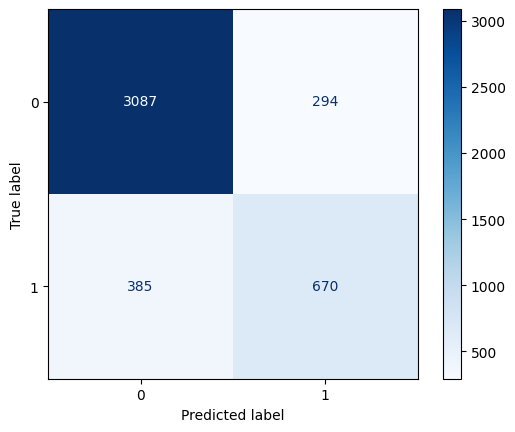

In [19]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8469
Precision: 0.6950
Recall: 0.6351
F1 Score: 0.6637


### Using two Conv1D layers is not improving the performance of the model. So one Conv1D layer is enough to train the model

## Single Conv1D Layer (With Batch Normalization)

In [21]:
# Define the CNN model
model3 = Sequential()

# Add a Conv1D layer
model3.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model3.add(MaxPooling1D(pool_size=2))

#Peform BatchNormalization
model3.add(BatchNormalization())

# Add a Flatten layer to convert 3D data to 1D
model3.add(Flatten())

# Add a Dense layer
model3.add(Dense(128, activation='relu'))
# Add a Dropout layer to prevent overfitting
model3.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model3.add(Dense(1, activation='sigmoid'))

# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 296, 128)          768       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 148, 128)          0         
 g1D)                                                            
                                                                 
 batch_normalization (Batch  (None, 148, 128)          512       
 Normalization)                                                  
                                                                 
 flatten_2 (Flatten)         (None, 18944)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2424960   
                                                                 
 dropout_2 (Dropout)         (None, 128)              

In [22]:
model3.fit(X_train_resampled, y_train_resampled,
           validation_split=0.2,
           epochs=50,
           batch_size=64)

Epoch 1/50
338/338 [==============================] - 5s 7ms/step - loss: 0.4707 - accuracy: 0.7756 - val_loss: 1.5554 - val_accuracy: 0.0126
Epoch 2/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3992 - accuracy: 0.8257 - val_loss: 0.8897 - val_accuracy: 0.4270
Epoch 3/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3829 - accuracy: 0.8347 - val_loss: 0.9516 - val_accuracy: 0.4557
Epoch 4/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3657 - accuracy: 0.8473 - val_loss: 0.1559 - val_accuracy: 0.9549
Epoch 5/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3544 - accuracy: 0.8491 - val_loss: 0.8063 - val_accuracy: 0.5391
Epoch 6/50
338/338 [==============================] - 3s 8ms/step - loss: 0.3463 - accuracy: 0.8564 - val_loss: 0.6386 - val_accuracy: 0.6585
Epoch 7/50
338/338 [==============================] - 2s 6ms/step - loss: 0.3373 - accuracy: 0.8574 - val_loss: 0.9553 - val_accuracy: 0.4720
Epoch 

In [23]:
y_pred = (model3.predict(X_test) > 0.5).astype("int32")

139/139 [==============================] - 0s 2ms/step


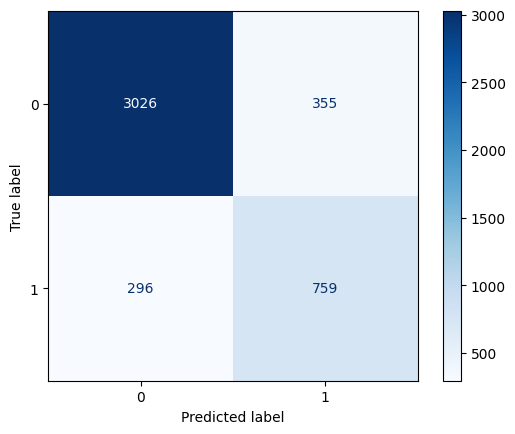

In [24]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [25]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8532
Precision: 0.6813
Recall: 0.7194
F1 Score: 0.6999


### With Batch Normalization, the recall value is increasing. But the overall F1-score is decreased. So no need to implement batch normalization

## Model Tuning


### Implement early stopping and learning rate reduction techniques, while ensuring that 'y_pred' achieves a balanced precision and recall.

In [32]:
# Define the CNN model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_resampled.shape[1], X_train_resampled.shape[2])))

# Add a MaxPooling layer
model.add(MaxPooling1D(pool_size=2))

# Add a Flatten layer to convert 3D data to 1D
model.add(Flatten())

# Add a Dense layer
model.add(Dense(128, activation='relu'))
# Add a Dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add the output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 296, 128)          768       
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 148, 128)          0         
 g1D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 18944)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               2424960   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                      

### Early stopping is a technique used to prevent overfitting of a model to the training data. It works by monitoring the performance of the model on a separate validation dataset during training. If the performance (e.g., validation loss or accuracy) stops improving or starts deteriorating for a certain number of epochs, training is halted early. This prevents the model from continuing to learn patterns specific to the training data that do not generalize well to unseen data.

### Learning rate reduction is a technique to improve the convergence of the model during training. It involves reducing the learning rate when the validation performance plateaus. This helps the model to fine-tune more precisely towards the optimal parameters.

In [33]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

In [34]:
# Fit the model with early stopping and learning rate reduction
history = model.fit(X_train_resampled, y_train_resampled,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
338/338 [==============================] - 4s 6ms/step - loss: 0.4801 - accuracy: 0.7716 - val_loss: 0.4260 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 2/50
338/338 [==============================] - 2s 5ms/step - loss: 0.4017 - accuracy: 0.8247 - val_loss: 0.3361 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 3/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3903 - accuracy: 0.8319 - val_loss: 0.5489 - val_accuracy: 0.7249 - lr: 0.0010
Epoch 4/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3763 - accuracy: 0.8407 - val_loss: 0.5223 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 5/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3631 - accuracy: 0.8456 - val_loss: 0.5372 - val_accuracy: 0.7410 - lr: 0.0010
Epoch 6/50
338/338 [==============================] - 2s 5ms/step - loss: 0.3412 - accuracy: 0.8592 - val_loss: 0.3332 - val_accuracy: 0.8688 - lr: 1.0000e-04
Epoch 7/50
338/338 [==============================] - 2s 6ms/step 

## Choose a threshold that balances precision and recall.

In [35]:
y_pred_prob = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Threshold
best_threshold = thresholds[np.argmax(precision * recall)]
y_pred = (y_pred_prob >= best_threshold).astype(int)

139/139 [==============================] - 0s 2ms/step


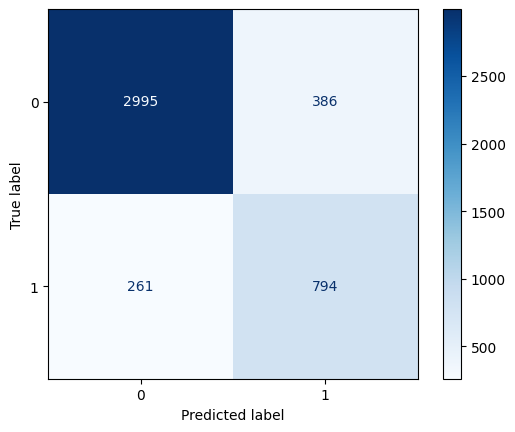

In [36]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.8541
Precision: 0.6729
Recall: 0.7526
F1 Score: 0.7105
